In [1]:
import sys, os, time
import shutil

# %pdb

# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision

from contextlib import nullcontext, redirect_stdout, redirect_stderr

from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
# plt.switch_backend('Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from bisect import bisect_left, bisect_right

# from IPython.display import HTML, Image

#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data
from analyze import *

from tqdm import tqdm_notebook as tqdm

plt.ioff()

np.set_printoptions(linewidth=120, suppress=True)

In [2]:
# M = Hybrid_Controller().filter_strs('!test')

In [3]:
root = '/is/ei/fleeb/workspace/media/transfer/results/val/box'

In [4]:
root = '/is/ei/fleeb/workspace/media/transfer/results/final/box'
# root = '/is/ei/fleeb/workspace/media/transfer/results/final/nocap'

In [5]:
mnames = ['ae', 'wae', 'vae1', 'vae4', 'fwae', 'fvae', 'fae', 'dae']
mname = mnames[1]
mname

'wae'

In [6]:
mres = [os.path.join(root, fname) for fname in os.listdir(root) if mname + '--' in fname[:len(mname)+2]]
print('Found {} ckpt results for {}'.format(len(mres), mname))

Found 51 ckpt results for wae


In [7]:
snames = ['box', 'cyl', 'sph', 'cap']
# snames = ['cap']

In [8]:
# shape = ''

def _smooth(x):
    
    return (x[1:] + x[:-1])/2

def _moments(samples, k='L'):
    
    mean = samples.mean().item()

    sig = samples.std().item() / np.sqrt(len(samples))
    
    return mean, sig
    
def calc_motion(Q,Qref):
    D = (Q-Qref).pow(2).sum(-1)

    return _moments(D)
    
def normalize(Q):
#     Q = R[sname]['Q']
    Q -= Q.mean(0, keepdim=True)
    Q /= Q.std(0, keepdim=True)
    return Q
    
def _extract_motion(R, ref):
    
    motion = []
    
    
    for sname in snames:
        
        Qref = normalize(Qref)
        
        Q = normalize(Q)
        
        motion.append(calc_motion(Q, Qref))
    return motion

# rec_errors = np.array([_extract_moments(R, k='L') for R in Rs])
# latent_motion = np.array([_extract_motion(R,Rs[max(i-1,0)]) for i, R in enumerate(Rs)])
# # latent_motion = np.array([_extract_motion(R,Rs[0]) for i, R in enumerate(Rs)])
# rec_errors.shape, latent_motion.shape

In [19]:
mnames

['ae', 'wae', 'vae1', 'vae4', 'fwae', 'fvae', 'fae', 'dae']

In [20]:
mnames = ['ae', 'wae', 'vae1', 'vae4', 'fwae', 'fvae', 'dae']

In [35]:
def _collect_data(root, mnames, latent_motions=None):
    if latent_motions is None:
        latent_motions = {}
    
    steps = None

    for mname in tqdm(mnames):

        mres = [os.path.join(root, fname) for fname in os.listdir(root) if mname + '--' in fname[:len(mname)+2]]
#         print('Found {} ckpt results for {}'.format(len(mres), mname))

        Rs = [torch.load(r) for r in mres]
        Rs = sorted(Rs, key=lambda R: R['steps'])

        if steps is None:
            steps = [R['steps'] for R in Rs]

        ref = None

        if mname in errors and mname in latent_motions:
            print('skipping {}'.format(mname))
            continue
        else:
#             if mname not in errors:
#                 errors[mname] = []
            if mname not in latent_motions:
                latent_motions[mname] = []

            for R in Rs:

#                 errors[mname].append(_moments(torch.cat([R[sname]['L'] for sname in snames])))


                Q = torch.cat([R[sname]['Q'] for sname in snames])
                Q = normalize(Q)

                if ref is not None:
                    latent_motions[mname].append(calc_motion(Q, ref))
        #         else:
        #             ref = Q
                ref = Q
            latent_motions[mname] = np.array(latent_motions[mname])
#             errors[mname] = np.array(errors[mname])
        #     errors[mname] = (errors[mname][1:] + errors[mname][:-1])/2
#             errors[mname] = _smooth(errors[mname])
#             print(latent_motions[mname].shape, )#errors[mname].shape)

    return latent_motions, steps

In [36]:
mnames = ['ae', 'wae', 'vae1', 'vae4', 'fwae', 'fvae', 'dae']

In [37]:
box, bsteps = _collect_data('/is/ei/fleeb/workspace/media/transfer/results/final/box', 
                    mnames, latent_motions=None)

In [38]:
nocap, nsteps = _collect_data('/is/ei/fleeb/workspace/media/transfer/results/final/nocap', 
                    mnames, latent_motions=None)

In [44]:
len(nsteps), len(bsteps)

(30, 51)

In [52]:
all_steps = [bsteps, nsteps]
all_steps = map(np.array, all_steps)
all_steps = [(steps[1:] + steps[:-1])/2 for steps in all_steps]
all_dats = [box, nocap]

all_dats = [{k:_smooth(v) for k,v in dat.items()} for dat in all_dats]
all_steps = [_smooth(steps) for steps in all_steps]

all_stages = [[80100, 100100, 120100], [100100]]

In [64]:
mnames = ['ae', 'wae', 'vae1', 'vae4', 'fwae', 'fvae', 'dae']
newmnames = ['AE', 'WAE', 'VAE', '4-VAE', 'FWAE', 'FVAE', 'DAE']

for dat in all_dats:
    for mname, nname in zip(mnames, newmnames):
        dat[nname] = dat[mname]
        del dat[mname]

In [65]:
def _populate(X, dat, stage_limits):
    colors = ['C{}'.format(i) for i in range(len(dat))]
    
    full = []

    for i, (mname, c) in enumerate(zip(newmnames, colors)):
        m, s = dat[mname].T
    #     m, s = errors[mname].T

#         m, s = _smooth(latent_motions[mname]).T

        full.append(m)
        plt.fill_between(X, y1=m-2*s, y2=m+2*s, color=c, alpha=0.3)
        plt.plot(X, m, label=mname)
        
        
    full = np.stack(full)
    ylims = full.max()*1.01, full.min()*0.99

    for slim in stage_limits:
        plt.plot([slim, slim], ylims, ls='--', color='k')

<IPython.core.display.Javascript object>


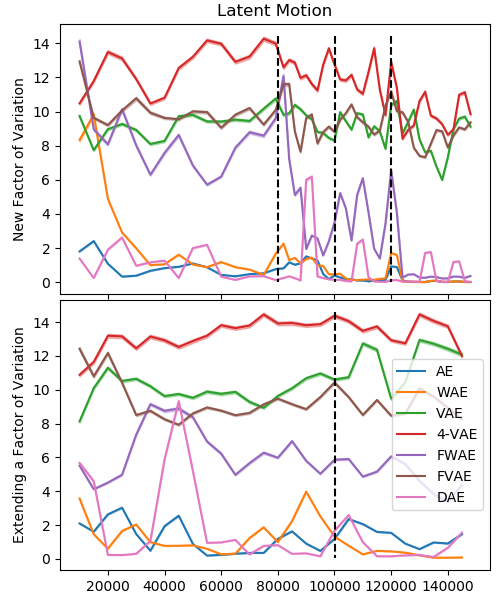

In [69]:
fig, axes = plt.subplots(2, figsize=(5,6), sharex=True)
axes = axes.flat


plt.sca(axes[0])
_populate(all_steps[0], all_dats[0], all_stages[0])

plt.title('Latent Motion')

plt.ylabel('New Factor of Variation')

plt.sca(axes[1])
_populate(all_steps[1], all_dats[1], all_stages[1])

plt.ylabel('Extending a Factor of Variation')

border, between = 0.02, 0.01

plt.subplots_adjust(wspace=between, hspace=2*between,
		                    left=0.12, right=1 - border, bottom=.05, top=1 - .04)

plt.legend()

fig

In [71]:
# fig.savefig('figures/latent_motion.pdf')

In [ ]:

full = []

X = steps
X = _smooth(steps)

colors = ['C{}'.format(i) for i in range(len(latent_motions))]

for i, (mname, c) in enumerate(zip(sel, colors)):
#     m, s = latent_motions[mname].T
#     m, s = errors[mname].T

    m, s = _smooth(latent_motions[mname]).T
    
    full.append(m)
    plt.fill_between(X, y1=m-2*s, y2=m+2*s, color=c, alpha=0.3)
    plt.plot(X, m, label=mname)
#     plt.plot(X, rec_errors[:,:,0], label=sname)

full = np.stack(full)

ylims = full.max()*1.01, full.min()*0.99

print(ylims)
for slim in stage_limits:
    plt.plot([slim, slim], ylims, ls='--', color='k')

# plt.ylim(3400,3600)
    
plt.legend()
pass

In [23]:
steps = np.array(steps)
steps = (steps[1:] + steps[:-1])/2
len(steps)

50

In [24]:
# steps = [R['steps'] for R in Rs]
stage_limits = []
stage_limits = [80100, 100100, 120100]
# stage_limits = [100100]

In [25]:
sel = mnames.copy()
# sel = ['ae', 'wae', 'dae', 'vae1', 'vae4', 'fvae', 'fwae']

<IPython.core.display.Javascript object>


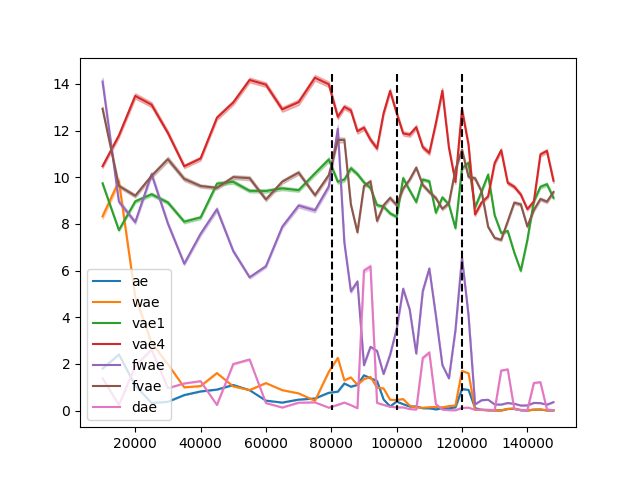

(14.408180594444275, 0.010221541780047118)


In [26]:
plt.subplots()

full = []

X = steps
X = _smooth(steps)

colors = ['C{}'.format(i) for i in range(len(latent_motions))]

for i, (mname, c) in enumerate(zip(sel, colors)):
#     m, s = latent_motions[mname].T
#     m, s = errors[mname].T

    m, s = _smooth(latent_motions[mname]).T
    
    full.append(m)
    plt.fill_between(X, y1=m-2*s, y2=m+2*s, color=c, alpha=0.3)
    plt.plot(X, m, label=mname)
#     plt.plot(X, rec_errors[:,:,0], label=sname)

full = np.stack(full)

ylims = full.max()*1.01, full.min()*0.99

print(ylims)
for slim in stage_limits:
    plt.plot([slim, slim], ylims, ls='--', color='k')

# plt.ylim(3400,3600)
    
plt.legend()
pass

In [61]:
# mres = [os.path.join(root, fname) for fname in os.listdir(root) if mname + '--' in fname[:len(mname)+2]]
# print('Found {} ckpt results for {}'.format(len(mres), mname))

In [62]:
# R = torch.load(mres[4])
# R.keys()

In [63]:
# R['steps']

150000

In [49]:
R['box'].keys()

dict_keys(['L', 'Q', 'R', 'originals'])

In [13]:
name = 'cap'

In [46]:
# show_nums(R[name]['originals'])
# pass

In [45]:
# show_nums(R[name]['R'])
# pass

In [16]:
# reconstruction


In [17]:
len(mres)

51

In [18]:
Rs = [torch.load(r) for r in mres]
Rs = sorted(Rs, key=lambda R: R['steps'])
len(Rs)

51

In [24]:
Rs[0].keys()

dict_keys(['box', 'cyl', 'sph', 'cap', 'name', 'path', 'cpath', 'ckpt', 'steps'])

In [32]:
# fix order

steps = [R['steps'] for R in Rs]
stage_limits = [80100, 100100, 120100]

In [20]:
snames = ['box', 'cyl', 'sph', 'cap']

<IPython.core.display.Javascript object>


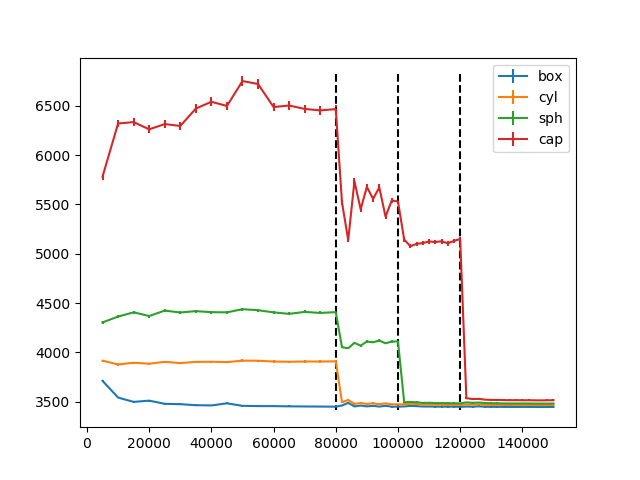

(6817.003383789062, 3412.6339306640625)


In [43]:
plt.subplots()



for s, sname in enumerate(snames):
    plt.errorbar(steps, rec_errors[:,s,0], yerr=2*rec_errors[:,s,1], label=sname)
#     plt.plot(X, rec_errors[:,:,0], label=sname)
plt.legend()

ylims = rec_errors[:,:,0].max()*1.01, rec_errors[:,:,0].min()*0.99

print(ylims)
for slim in stage_limits:
    plt.plot([slim, slim], ylims, ls='--', color='k')

pass

<IPython.core.display.Javascript object>


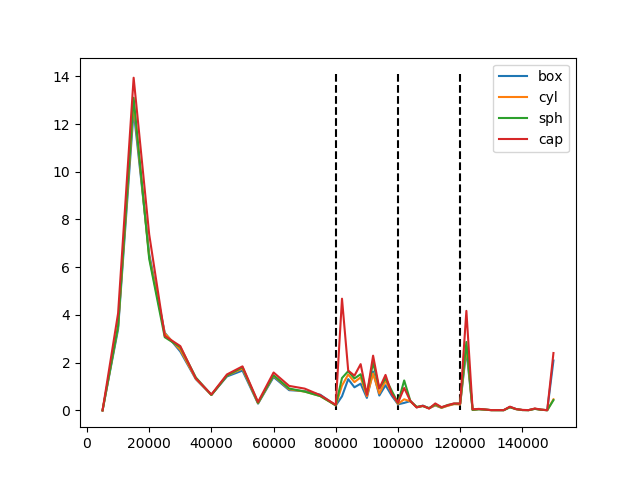

(14.078628044128418, 0.0)


In [44]:
plt.subplots()

for s, sname in enumerate(snames):
    plt.errorbar(steps, latent_motion[:,s,0], label=sname)# yerr=2*latent_motion[:,s,1], label=sname)
#     plt.plot(X, rec_errors[:,:,0], label=sname)

ylims = latent_motion[:,:,0].max()*1.01, latent_motion[:,:,0].min()*0.99

print(ylims)
for slim in stage_limits:
    plt.plot([slim, slim], ylims, ls='--', color='k')

plt.legend()
pass

In [ ]:

fig, ax = plt.subplots()



In [36]:
for k,v in results.items():
    
    print(k, v['L'].mean().item())


box 3566.449462890625
cyl 3856.5048828125
sph 4321.7529296875
cap 6180.55322265625


In [45]:
for k,v in results.items():
    
    print(k, v['L'].mean().item())


box 3446.47216796875
cyl 3908.31201171875
sph 4380.01318359375
cap 6341.4814453125


In [46]:
X, = next(iter(loader))
X.shape, Y.shape

ValueError: not enough values to unpack (expected 2, got 1)

In [14]:
# full = trn.get_dataset('3dshapes')

In [123]:
# box = trn.get_dataset('byfactor', counts=[-1,0,0,0])
box = None
cyl = trn.get_dataset('byfactor', counts=[0,2000,0,0])
cyl = fd.data.Subset_Dataset(cyl, np.arange(1000)+600)
# sph = trn.get_dataset('byfactor', counts=[0,0,1600,0])
dataset = cyl

Loading dataset: byfactor
factor: shape (by default)
vals: None (by default)
counts: [0, 2000, 0, 0]
seeds: None (by default)
det: True (by default)
labeled: False (by default)
dataroot: /is/ei/fleeb/workspace/local_data
load_memory: True (by default)
train: True (by default)
labeled: True
noise: None (by default)
din: (3, 64, 64) (by default)
dout: 6 (by default)
Filtering out 382000/384000 samples


In [124]:
def _loadrun(run, ref=False):
    
    if 'state' not in run:
    
        state = run.reset()
        
        if not ref:
            state.dataset = dataset

        run.load()

        del state.loader
        del state.batch
        del state.X

        return state
    return run.state

In [125]:
S = _loadrun(ref, ref=True)
box = fd.data.Subset_Dataset(S.valset, np.arange(1000))

In [126]:
Ss = M.map(_loadrun)
len(M)

3

In [127]:
len(box), len(cyl)

(1000, 1000)

In [128]:
border, between = 0.02, 0.01

In [129]:
M[0].config.dataset

{{'batch_size':128, 'counts':[-1, 0, 0, 0], 'drop_last':False, 'factor':'shape', 'name':'byfactor', 'shuffle':True, 'val_split':0.1, '_ipython_canary_method_should_not_exist_':{{}}}}

In [130]:
dataset = cyl

In [131]:
util.set_seed(0)
B = 16
idx = np.random.randint(len(dataset), size=(B,))
idx

array([684, 559, 629, 192, 835, 763, 707, 359,   9, 723, 277, 754, 804, 599,  70, 472])

In [132]:
X, = dataset[idx]
X = X.to('cuda')
B = X.size(0)
X.shape

torch.Size([16, 3, 64, 64])

<IPython.core.display.Javascript object>


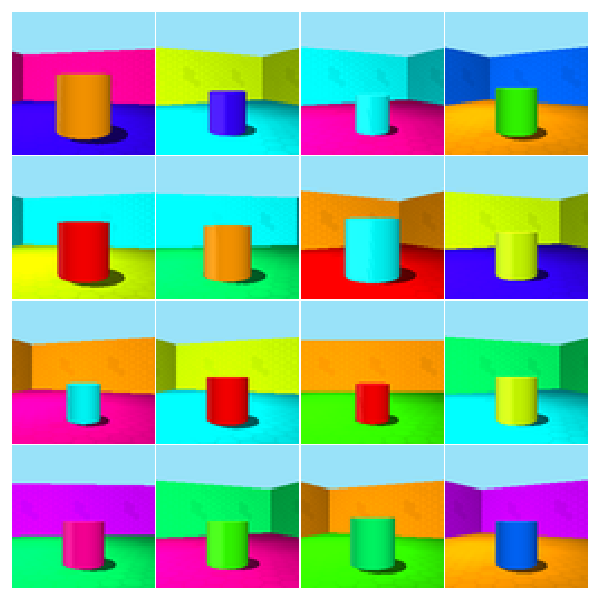

In [133]:
fig = show_nums(X)
plt.subplots_adjust(wspace=between, hspace=between,
	                    left=border, right=1 - border, bottom=border, top=1 - border)
pass

In [134]:
criterion = S.model.criterion
criterion.reduction = 'none'

In [135]:

def _fn(run):
    s = run.state
    
    Q = []
    L = []
    R = []
    
    batch_size = 200
    
    loader = trn.get_loaders(dataset, batch_size=batch_size, shuffle=False)
    
    with torch.no_grad():
        
        q = s.model.encode(X)
        if isinstance(q, distrib.Distribution):
            q = q.mu
        s.rec = s.model.decode(q)
        s.q = q
        
        for batch in loader:
            batch = util.to(batch, s.A.device)
            x = batch[0]
            
            q = s.model.encode(x)
            
            if isinstance(q, distrib.Distribution):
                q = q.mu
            Q.append(q)
            
            rec = s.model.decode(q)
            
            loss = criterion(x, rec)
            loss = loss.view(batch_size,-1).sum(-1)
            
            R.append(rec)
            L.append(loss)
        
        Q = torch.cat(Q).cpu()
        L = torch.cat(L).cpu().view(-1)
        R = torch.cat(R).cpu()
        
        
        s.Q = Q
        s.L = L
        s.R = R
        
#     return s.rec

M.map(_fn)
pass

Using batched data loader
Using batched data loader
Using batched data loader


<IPython.core.display.Javascript object>


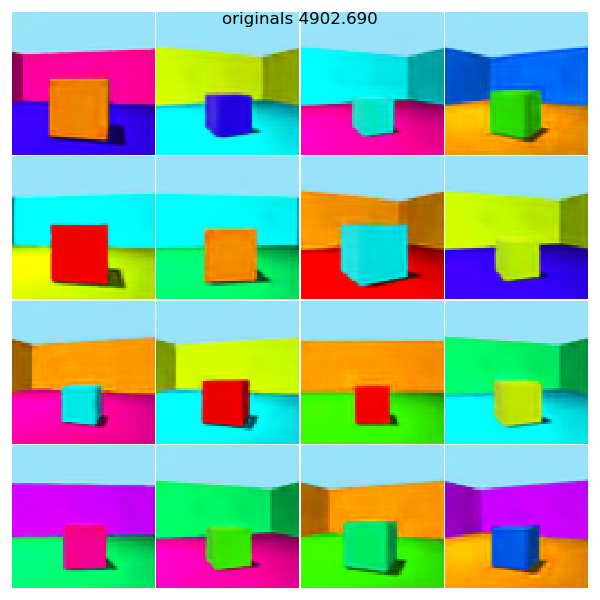

<IPython.core.display.Javascript object>


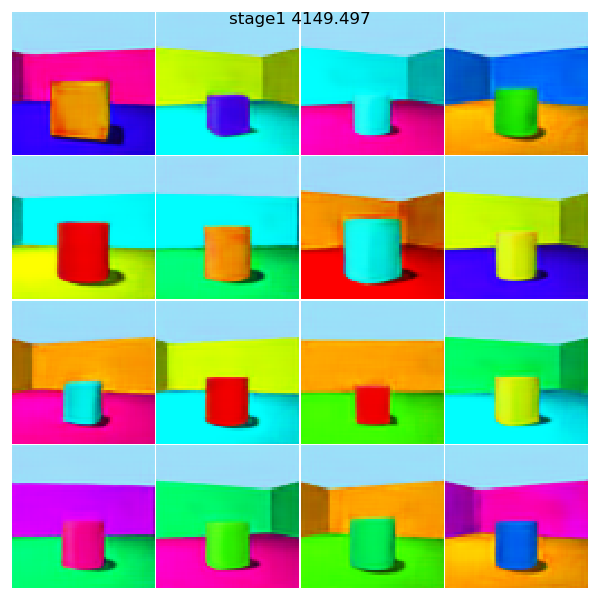

<IPython.core.display.Javascript object>


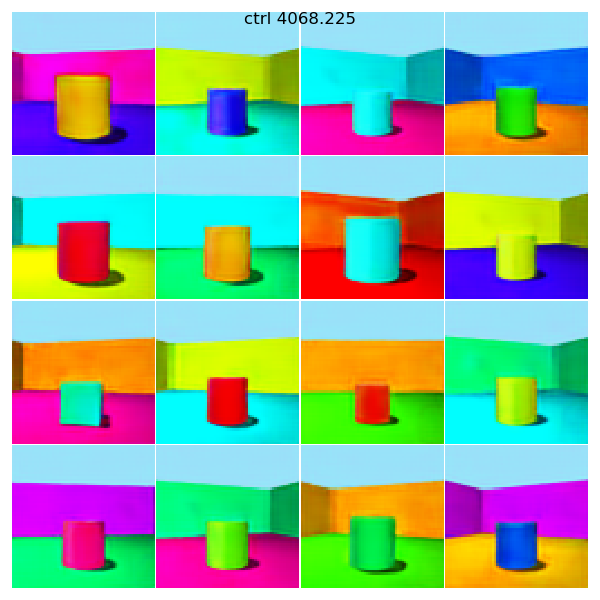

In [136]:
def _fn(run):
    s = run.state
    fig = show_nums(s.rec)
    fig.suptitle('{} {:.3f}'.format(run.stage, s.L.mean().item()))
    plt.subplots_adjust(wspace=between, hspace=between,
                            left=border, right=1 - border, bottom=border, top=1 - border)
    return fig
figs = M.map(_fn)

In [117]:
data = {}
for r in M:
    data[r.stage] = r.state.L.numpy()
    print(data[r.stage].max())

9898.107
6028.9307
16049.301


In [137]:
df = pd.DataFrame({r.stage:r.state.L.numpy() for r in M})

In [138]:
r.state.L.numpy().max()

13997.037

In [139]:
df = pd.melt(df, id_vars=None, var_name='cat', value_name='val')

In [140]:
hue = None
split = False
color = 'C0'
inner = 'box'
palette = None

<IPython.core.display.Javascript object>


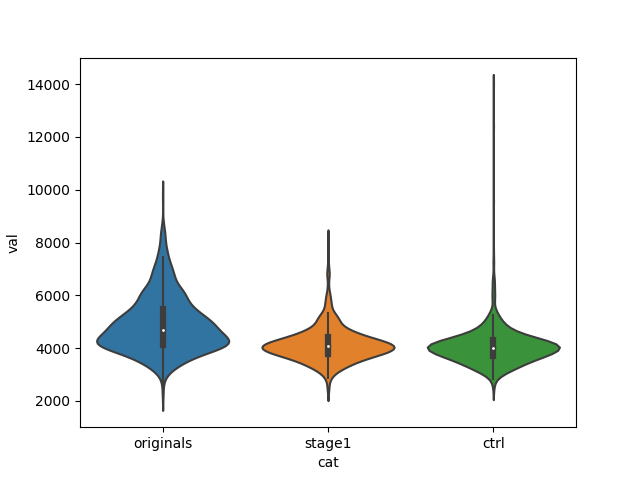

In [141]:
plt.figure()
sns.violinplot(x='cat', y='val', # color=color,
		               data=df, split=split, palette=palette,
		               scale="count", inner=inner, gridsize=100,)
pass

In [97]:
s = M[1].state

In [98]:
s.R.shape

torch.Size([1000, 3, 64, 64])

In [99]:
s.L.shape

torch.Size([1000])

In [100]:
s.L.max(0)

torch.return_types.max(
values=tensor(19978.5195),
indices=tensor(418))

In [101]:
len(dataset)

1000

In [102]:
o = 418

In [103]:
s.L[o-2:o+2]

tensor([ 4315.7998,  4038.1104, 19978.5195,  4070.2913])

<IPython.core.display.Javascript object>


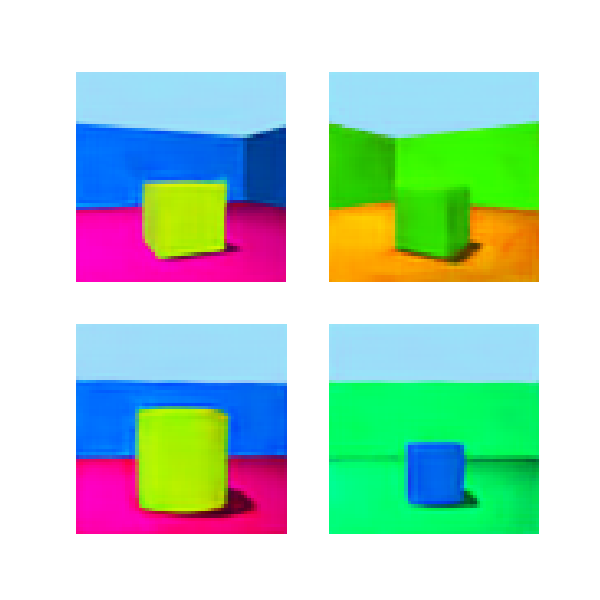

In [104]:
show_nums(s.R[o-2:o+2])
pass

<IPython.core.display.Javascript object>


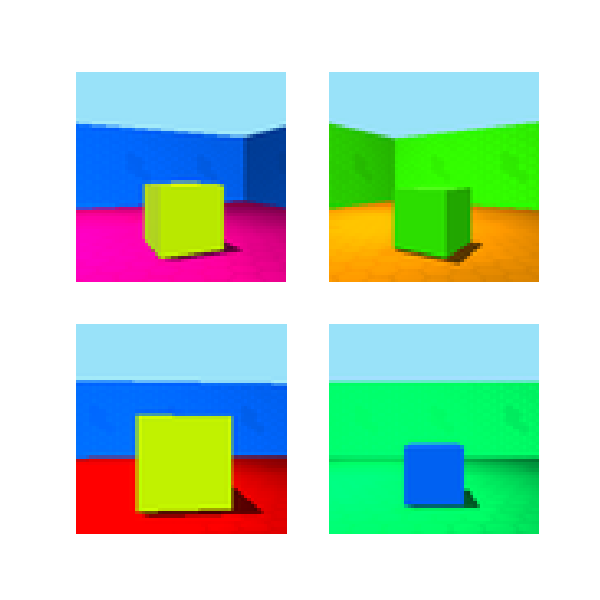

In [105]:
show_nums(dataset[o-2:o+2][0])
pass